# PCA of Cards
Tristan Miller, 5/5/2018

I want to apply PCA to the cards, using the synergy factor matrix as the features of each card--although I'm renaming all the concepts for clarity.  My initial guess is that the first component will be "villaginess vs terminalness" and the second component will be "slogginess vs thinness".

I also need to visually represent the results.  Perhaps a labeled graph would work.  Or maybe word clouds.

## Defining terms
I define two binary relations between cards: prom(X,Y), and love(X,Y).

prom(X,Y) is the change in gain percentage of Y, when X is in the supply, relative to the average gain percentage.  If prom(X,Y) > 0, I say X "promotes" Y.

love(X,Y) is how much Y promotes X, compared to how much Y promotes other cards.  If love(X,Y) > 0, I say X "loves" Y.

Here are the formal mathematical definitions for each relation:

$\mathrm{prom}(X,Y) = P(\mathrm{gain}(Y)|\mathrm{supply}(X)\&\mathrm{supply}(Y)) - P(\mathrm{gain}(Y)|\mathrm{supply}(Y))$

$\mathrm{love}(X,Y) = \mathrm{prom}(Y,X) - \sum_{Y_i} \mathrm{prom}(Y_i,X) / N$



## Defining features
For each kingdom card X, I want features for prom(X,Y) and love(X,Y), for each kingdom card Y.  I also want to apply normalization so that cards can be compared on the basis of type rather than the strength of their synergies.  I want to weight the factors such that love and prom have similar contributions.  And finally, I apply weighting to account for the statistical significance of each column.

The normalized columns will be:
$$prom(X,Y) / \sum_Y (prom(X,Y)^2)$$
and
$$love(X,Y) / \sum_Y (love(X,Y)^2)$$

To weight by statistical significance, I divide each Y-related column by the square root of the number of games with Y.  Then I multiply by a constant factor to bring the average weight up to 1.

In [1]:
#packages
import os
import re
import pdb
import numpy as np
import pickle
import time
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sklearn.semi_supervised as semi
from sklearn.cluster import SpectralClustering as spectral

## Creating table of features

In [126]:
#load pickles
with open('gain_matrices.pkl','rb') as f:
    num_games, game_gains, total_gains = pickle.load(f)
with open('card_list.pkl','rb') as f:
    card_list,card_dict = pickle.load(f)
    
#calculate prom(X,Y)
prc_gains = game_gains / num_games
base_gain = prc_gains[card_dict['Copper'],:].copy()
prom = prc_gains - base_gain #this subtracts each row (not col) by base_gain

#Create a list of cards to exclude
excluded_cards = ['Copper','Silver','Gold','Estate','Duchy','Province','Curse','Colony','Platinum','Ruins','Potion']
#recalculate card list and dict in light of excluded cards
kingdom_list = [card for card in card_list if card not in excluded_cards]
kingdom_dict = {card:i for i,card in enumerate(kingdom_list)}
#drop rows and columns corresponding to excluded cards:
card_excluder = [card_dict[card] for card in excluded_cards]
prom = np.delete(prom,card_excluder,axis=0)
prom = np.delete(prom,card_excluder,axis=1)

#normalize prom so that each row has magnitude 1
prom_norm_factor = np.sum(prom**2,axis = 1)**0.5
prom_norm = (prom.transpose() / prom_norm_factor).transpose()

#calculate love(X,Y)
love = prom.copy().transpose()
base_love = np.mean(love,axis=0)
love -= base_love

#Normalize love so that each row has magnitude 1
love_norm_factor = np.sum(love**2,axis = 1)**0.5
love_norm = (love.transpose() / love_norm_factor).transpose()

#Now, create a DataFrame with the full list of features
prom_data = {('P: ' + card):prom_norm[:,i] for i,card in enumerate(kingdom_list)}
love_data = {('L: ' + card):love_norm[:,i] for i,card in enumerate(kingdom_list)}
card_vectors = pd.DataFrame({**prom_data,**love_data})
card_vectors.index = kingdom_list
#reorder columns to be consistent with rows
ordered_cols = [('P: ' + card) for card in kingdom_list]+[('L: ' + card) for card in kingdom_list]
card_vectors = card_vectors[ordered_cols]

In [127]:
#weight columns by their statistics
stat_weight = [num_games[card_dict[card],card_dict[card]]**0.5 for card in kingdom_list]
weight_norm = np.mean(stat_weight)
stat_weight = stat_weight / weight_norm
stat_weight = np.concatenate((stat_weight,stat_weight))

for card in kingdom_list:
    card_vectors['L: '+card] *= stat_weight[kingdom_dict[card]]
    card_vectors['P: '+card] *= stat_weight[kingdom_dict[card]]

## Applying PCA

In [128]:
start_time = time.time()
model = PCA(n_components=10)
reduced_vectors = model.fit_transform(card_vectors)
model_components = model.components_
processing_time = (time.time() - start_time)/60
print("Time to execute: %.2f minutes" % processing_time )

Time to execute: 0.00 minutes


In [149]:
%matplotlib inline

#By default, makes a scatter plot of any two components.
#by changing axis1_type or axis2_type to 'prom', it will instead show what cards are most promoted by this component
#and by changing to 'love', it will instead show what cards most loved by this component.
#for display purposes, I index the components starting with 1
def pca_map(axis1,axis2,axis1_type='card',axis2_type='card',size=(18,13)):
    plt.figure(figsize=size)
    if( axis1_type == 'card' ):
        component1 = reduced_vectors[:,axis1]
        plt.xlabel('Component %i' % (axis1+1),fontsize=16)
    elif( axis1_type == 'prom' ):
        component1 = model_components[axis1,0:len(kingdom_list)].transpose()
        plt.xlabel('Promoted by component %i' % (axis1+1),fontsize=16)
    elif( axis1_type == 'love' ):
        component1 = model_components[axis1,len(kingdom_list):len(kingdom_list)*2].transpose()
        plt.xlabel('Loved by component %i' % (axis1+1),fontsize=16)
    else:
        raise Exception('Must choose "card","prom", or "love" as axis type.')
    
    if( axis2_type == 'card' ):
        component2 = reduced_vectors[:,axis2]
        plt.ylabel('Component %i' % (axis2+1),fontsize=16)
    elif( axis2_type == 'prom' ):
        component2 = model_components[axis2,0:len(kingdom_list)].transpose()
        plt.ylabel('Promoted by component %i' % (axis2+1),fontsize=16)
    elif( axis2_type == 'love' ):
        component2 = model_components[axis2,len(kingdom_list):len(kingdom_list)*2].transpose()
        plt.ylabel('Loved by component %i' % (axis2+1),fontsize=16)
    else:
        raise Exception('Must choose "card","prom", or "love" as axis type.')
        
    plt.scatter(component1, component2)
    for label, x, y in zip(kingdom_list, component1, component2):
        #plt.text(x,y+.1,label,ha='center', va='center')
        plt.annotate(label, xy = (x,y),xytext = (0,5),textcoords='offset points',ha='center',fontsize=12)
    plt.show()

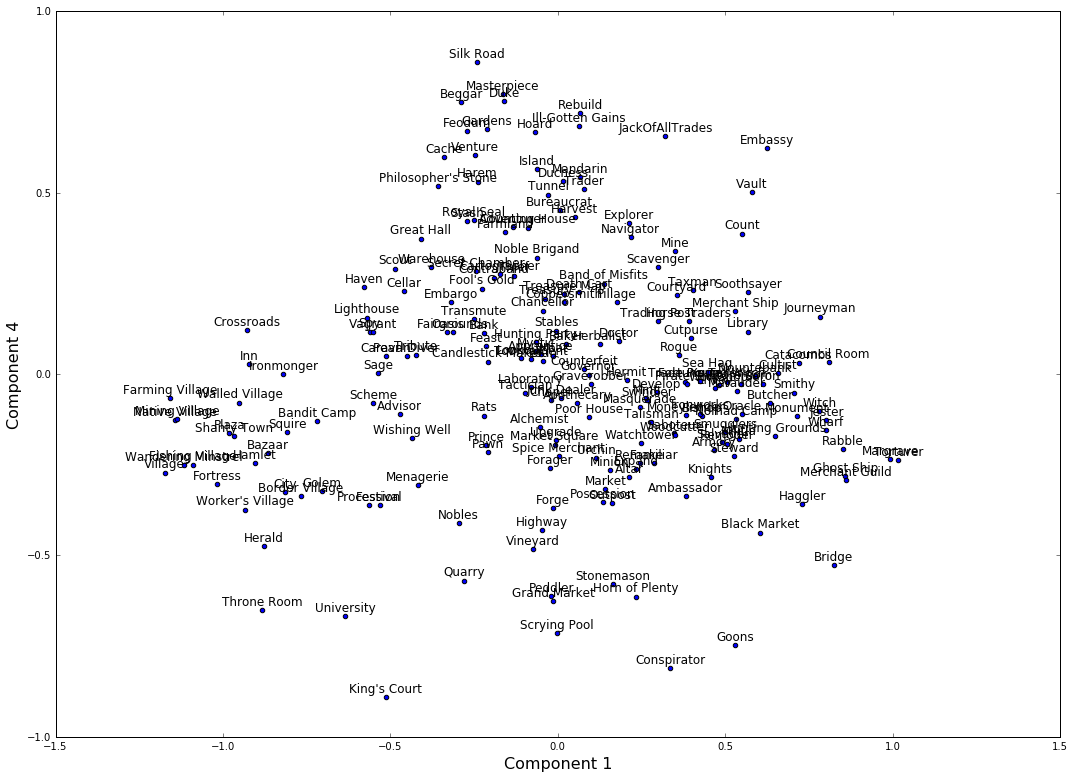

In [173]:
pca_map(0,3,axis2_type='card')

It looks like the components are:
1. terminals vs villages
2. 5-costs vs things to get 5-costs
3. thinners vs things best in thin decks
4. slog vs engine
5. Trashing vs draw
6. cheap cards and defense cards vs strong attacks and gainers
7. +Buy vs cards that promote big turns (?)
8. junkers vs ??
9. junkers vs ??
10. I really don't know

In [238]:
#Relative importance of each component:
print(model.explained_variance_)

[ 0.24399325  0.20182445  0.15005617  0.10892099  0.09377003  0.08707616
  0.06476528  0.04866089  0.04255631  0.04065931]


# Clustering
Since I have some idea for what kind of clusters I want, it would be nice to come up with some sort of semi-supervised clustering model.

One interesting possibility is label propagation, from the scikit-learn package:
http://scikit-learn.org/stable/modules/label_propagation.html

In [197]:
#seeds for the clusters
cluster_names = ['Village','Terminal Draw','Nonterminal Draw','Trashing','Junking','Gaining','Payoff','Victory']
cluster_seeds = [['Village','Native Village','Throne Room','Bazaar','Border Village'],
                 ['Smithy','Courtyard','Catacombs','Library','Wharf'],
                 ['Laboratory','Caravan','Stables','Alchemist','Hunting Party','Advisor','Menagerie'],
                 ['Chapel','Moneylender','Lookout','Junk Dealer','Doctor','Forge','Forager','Count','Loan'],
                ['Soothsayer','Sea Hag','Mountebank','Cultist','Marauder'],
                 ['Workshop','Ironworks','Smugglers','Altar','Talisman','Hermit','Armory'],
                ['Bridge','Butcher','Bank','Conspirator','Baron','Merchant Ship','Goons','Black Market'],
                 ['Gardens','Duke','Fairgrounds','Silk Road']]

#cluster_seeds = ['Village','Smithy','Laboratory','Chapel','Witch','Workshop','Woodcutter','Market','Gardens']

labels = np.zeros((len(kingdom_list)),dtype=int)-1
for i,seed in enumerate(cluster_seeds):
    #labels[kingdom_dict[seed]] = i
    for card in seed:
        labels[kingdom_dict[card]] = i

In [198]:
label_model = semi.LabelPropagation()
label_model.fit(card_vectors,labels)

#Get a list of cards in each cluster
clusters = [[] for i in range(len(cluster_seeds))]
for i,cluster_id in enumerate(label_model.transduction_):
    clusters[cluster_id].append(kingdom_list[i])

In [199]:
#print out the list
output_string = ''
for i,cluster in enumerate(clusters):
    output_string += '%s cluster:\n' % cluster_names[i]
    for card in cluster:
        output_string += card + '\t'
    output_string += '\n\n'
print(output_string)

Village cluster:
Village	Hamlet	Vagrant	Sage	Wandering Minstrel	Lighthouse	Royal Seal	Farming Village	City	Golem	Prince	Worker's Village	University	Thief	Fortress	Quarry	Tribute	Bazaar	Inn	Haven	Procession	Native Village	Walled Village	Herald	Pearl Diver	Border Village	Crossroads	Plaza	Squire	Shanty Town	King's Court	Nobles	Festival	Throne Room	Cellar	Fishing Village	Mining Village	Rats	Bandit Camp	

Terminal Draw cluster:
Envoy	Wharf	Secret Chamber	Library	Ghost Ship	Embassy	Oracle	Candlestick Maker	Smithy	Torturer	Embargo	Rabble	Courtyard	Hunting Grounds	Pawn	Catacombs	Moat	Council Room	Journeyman	Margrave	

Nonterminal Draw cluster:
Stables	Spy	Alchemist	Laboratory	Scrying Pool	Baker	Scheme	Caravan	Minion	Highway	Ironmonger	Market	Cartographer	Treasury	Menagerie	Venture	Watchtower	Hunting Party	Advisor	Governor	Wishing Well	Apothecary	Tactician	Tournament	Mystic	

Trashing cluster:
Warehouse	Trade Route	Forge	Junk Dealer	Remake	Moneylender	Masquerade	Expand	Oasis	Forager	Chapel	Appr

# Producing graphs


In [253]:
def pca_map_color(axis1,axis2,axis1_type='card',axis2_type='card',size=(18,13)):
    plt.figure(figsize=size)
    if( axis1_type == 'card' ):
        component1 = reduced_vectors[:,axis1]
        plt.xlabel('Component %i' % (axis1+1),fontsize=16)
    elif( axis1_type == 'prom' ):
        component1 = model_components[axis1,0:len(kingdom_list)].transpose()
        plt.xlabel('Promoted by component %i' % (axis1+1),fontsize=16)
    elif( axis1_type == 'love' ):
        component1 = model_components[axis1,len(kingdom_list):len(kingdom_list)*2].transpose()
        plt.xlabel('Loved by component %i' % (axis1+1),fontsize=16)
    else:
        raise Exception('Must choose "card","prom", or "love" as axis type.')
    
    if( axis2_type == 'card' ):
        component2 = reduced_vectors[:,axis2]
        plt.ylabel('Component %i' % (axis2+1),fontsize=16)
    elif( axis2_type == 'prom' ):
        component2 = model_components[axis2,0:len(kingdom_list)].transpose()
        plt.ylabel('Promoted by component %i' % (axis2+1),fontsize=16)
    elif( axis2_type == 'love' ):
        component2 = model_components[axis2,len(kingdom_list):len(kingdom_list)*2].transpose()
        plt.ylabel('Loved by component %i' % (axis2+1),fontsize=16)
    else:
        raise Exception('Must choose "card","prom", or "love" as axis type.')
        
    plt.scatter(component1, component2,lw=0,s=30,c=label_model.transduction_,cmap=plt.cm.Dark2)
    for label, x, y in zip(kingdom_list, component1, component2):
        #plt.text(x,y+.1,label,ha='center', va='center')
        plt.annotate(label, xy = (x,y),xytext = (0,7),textcoords='offset points',ha='center',fontsize=12)
    plt.show()

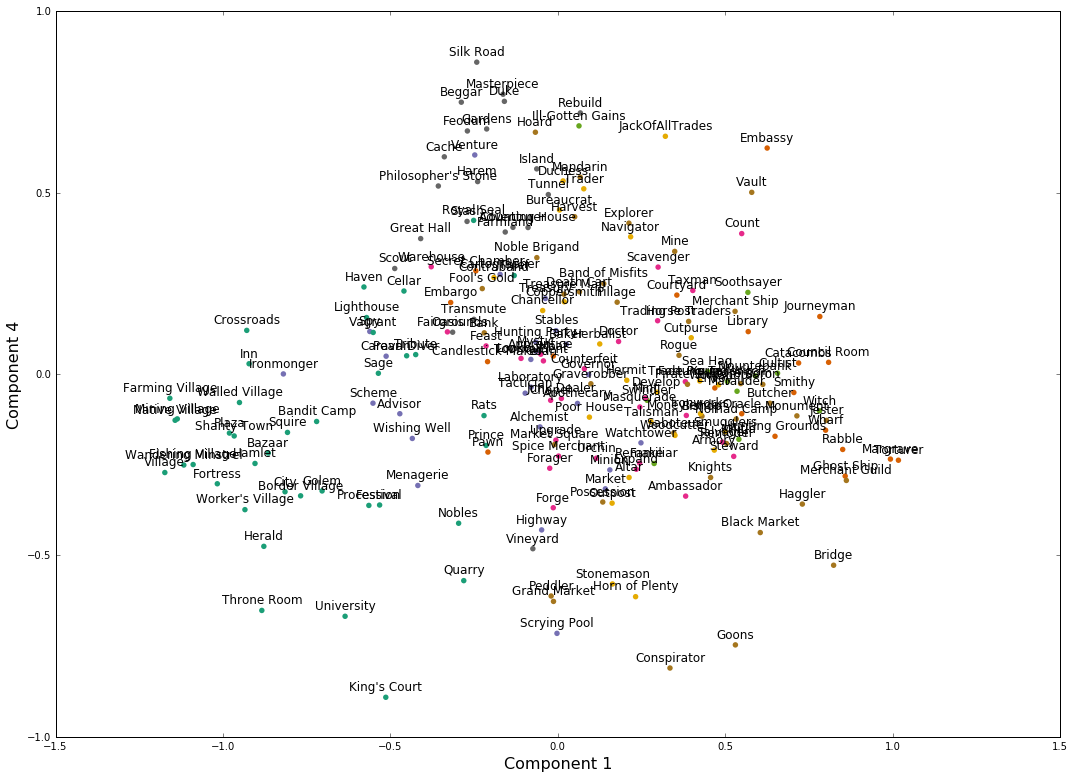

In [254]:
pca_map_color(0,3)

# Saving Pickles

In [255]:
#This is just the bare minimum required to produce the graphs above
with open('model_results.pkl', 'wb') as handle:
    pickle.dump((reduced_vectors, model_components, kingdom_list,label_model.transduction_),handle)

## Unsupervised Clustering
What if I try without any labeling?

I wasn't impressed with the results, so I may leave the code here but I'm not using it in graphs.

In [192]:
num_clusters = 9
spectral_model = spectral(n_clusters=num_clusters)
cluster_labels = spectral_model.fit_predict(card_vectors)

In [193]:
clusters = [[] for i in range(num_clusters)]
for i,cluster_id in enumerate(cluster_labels):
    clusters[cluster_id].append(kingdom_list[i])
    
output_string = ''
for i,cluster in enumerate(clusters):
    output_string += 'Cluster %i:\n' % (i+1)
    for card in cluster:
        output_string += card + '\t'
    output_string += '\n\n'
print(output_string)

Cluster 1:
Poor House	Haggler	Stonemason	Band of Misfits	Saboteur	Possession	Expand	Jester	Merchant Guild	Armory	Knights	Vineyard	Rogue	Workshop	Golem	Prince	University	Outpost	Altar	Grand Market	Herbalist	Counterfeit	Merchant Ship	Tribute	Ironworks	Graverobber	Procession	Horn of Plenty	Mint	Border Village	Pillage	Goons	Market Square	King's Court	Nobles	Festival	Woodcutter	Mine	Talisman	Butcher	

Cluster 2:
Cache	Contraband	Tunnel	Duchess	Mandarin	Chancellor	Royal Seal	JackOfAllTrades	Rebuild	Vault	Bank	Harem	Hoard	Transmute	Trader	Adventurer	Thief	Noble Brigand	Harvest	Feodum	Island	Venture	Counting House	Farmland	Stash	Gardens	Masterpiece	Duke	Treasure Map	Silk Road	Bureaucrat	Philosopher's Stone	Scout	Explorer	Great Hall	Beggar	Fool's Gold	Fairgrounds	

Cluster 3:
Warehouse	Hamlet	Vagrant	Secret Chamber	Sage	Lighthouse	Oasis	Scheme	Candlestick Maker	Embargo	Courtyard	Haven	Pearl Diver	Crossroads	Pawn	Squire	Moat	Wishing Well	Cellar	

Cluster 4:
Wharf	Library	Ghost Ship	Embassy	Smith